<a href="https://colab.research.google.com/github/Rizky28eka/UasAmikom/blob/main/BPDAL_KEL_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Project:** Analisis Kesehatan Mata menggunakan Machine Learning  
**Dataset:** NHIS Vision and Eye Health Surveillance

**Alasan Pemilihan:**
1. **Relevansi dengan kesehatan publik:**
   - Menyediakan informasi penting tentang kesehatan mata populasi.
   - Membantu identifikasi faktor risiko kesehatan mata.

2. **Dataset lengkap dengan multiple features:**
   - Fitur beragam untuk analisis komprehensif.
   - Dapat menghasilkan insight yang lebih bernilai.

3. **Potensi untuk classification task:**
   - Dapat memprediksi risiko gangguan penglihatan.
   - Mendukung kebijakan kesehatan preventif.

4. **Manfaat yang Diharapkan:**
   - **Penyuluhan Kesehatan Mata:** Program berbasis data untuk masyarakat.
   - **Prediksi dan Pencegahan:** Penanganan lebih awal bagi individu berisiko tinggi.
   - **Kontribusi pada Penelitian Medis:** Menambah referensi dalam pengembangan terapi dan kebijakan kesehatan.

LINK Dataset Kaggle : https://www.kaggle.com/datasets/prasad22/nhis-vision-and-eye-health-surveillance-dataset/data (8 month ago)

LINK Google Collab : https://colab.research.google.com/drive/1rQRSDUQ-DxZE7cW5yaYR3WFJYtx3Yan_?usp=sharing

LINK Github : https://github.com/Rizky28eka/UasAmikom/blob/main/BPDAL_Kel4.ipynb

In [37]:
# Import library yang diperlukan
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, DecisionTreeClassifier, NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt

# BAGIAN 1: PERSIAPAN DATA DAN LINGKUNGAN

In [ ]:
print("# 1. Persiapan Data dan Lingkungan")

# Inisialisasi Spark Session
spark = SparkSession.builder.appName("AnalisisKesehatanMata").getOrCreate()

# Membaca dataset
data_file = 'NHIS_Vision_and_Eye_Health_Surveillance_20240501.csv'
df = pd.read_csv(data_file)
print("Dimensi dataset:", df.shape)
print("\nInfo dataset:")
print(df.info())

# 1. Persiapan Data dan Lingkungan
Dimensi dataset: (71649, 36)

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71649 entries, 0 to 71648
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   YearStart                   71649 non-null  int64  
 1   YearEnd                     71649 non-null  int64  
 2   LocationAbbr                71649 non-null  object 
 3   LocationDesc                71649 non-null  object 
 4   DataSource                  71649 non-null  object 
 5   Topic                       71649 non-null  object 
 6   Category                    71649 non-null  object 
 7   Question                    71649 non-null  object 
 8   Response                    71649 non-null  object 
 9   Age                         71649 non-null  object 
 10  Gender                      71649 non-null  object 
 11  RaceEthnicity               71649 non-null  object 
 12  RiskFacto

# BAGIAN 2: PRE-PROCESSING DATA

In [ ]:
print("\n# 2. Pre-processing Data")

# Membuat salinan dataset
df_cleaned = df.copy()

# Menangani missing values
print("Jumlah missing values sebelum dibersihkan:")
print(df.isnull().sum())

# Mengisi missing values
for col in df_cleaned.columns:
    if df_cleaned[col].dtype in ['float64', 'int64']:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())
    else:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].mode()[0])

# Standardisasi data numerik
numerical_cols = ['Data_Value', 'Low_Confidence_Limit', 'High_Confidence_Limit', 'Sample_Size']
scaler = StandardScaler()
df_cleaned[numerical_cols] = scaler.fit_transform(df_cleaned[numerical_cols])


# 2. Pre-processing Data
Jumlah missing values sebelum dibersihkan:
YearStart                         0
YearEnd                           0
LocationAbbr                      0
LocationDesc                      0
DataSource                        0
Topic                             0
Category                          0
Question                          0
Response                          0
Age                               0
Gender                            0
RaceEthnicity                     0
RiskFactor                        0
RiskFactorResponse                0
Data_Value_Unit                   0
Data_Value_Type                   0
Data_Value                    38495
Data_Value_Footnote_Symbol    33154
Data_Value_Footnote           33154
Low_Confidence_Limit          38495
High_Confidence_Limit         38495
Numerator                     71649
Sample_Size                   17790
LocationID                        0
TopicID                           0
CategoryID                     

# BAGIAN 3: EXPLORATORY DATA ANALYSIS (EDA)


# 3. Analisis Data Eksploratif


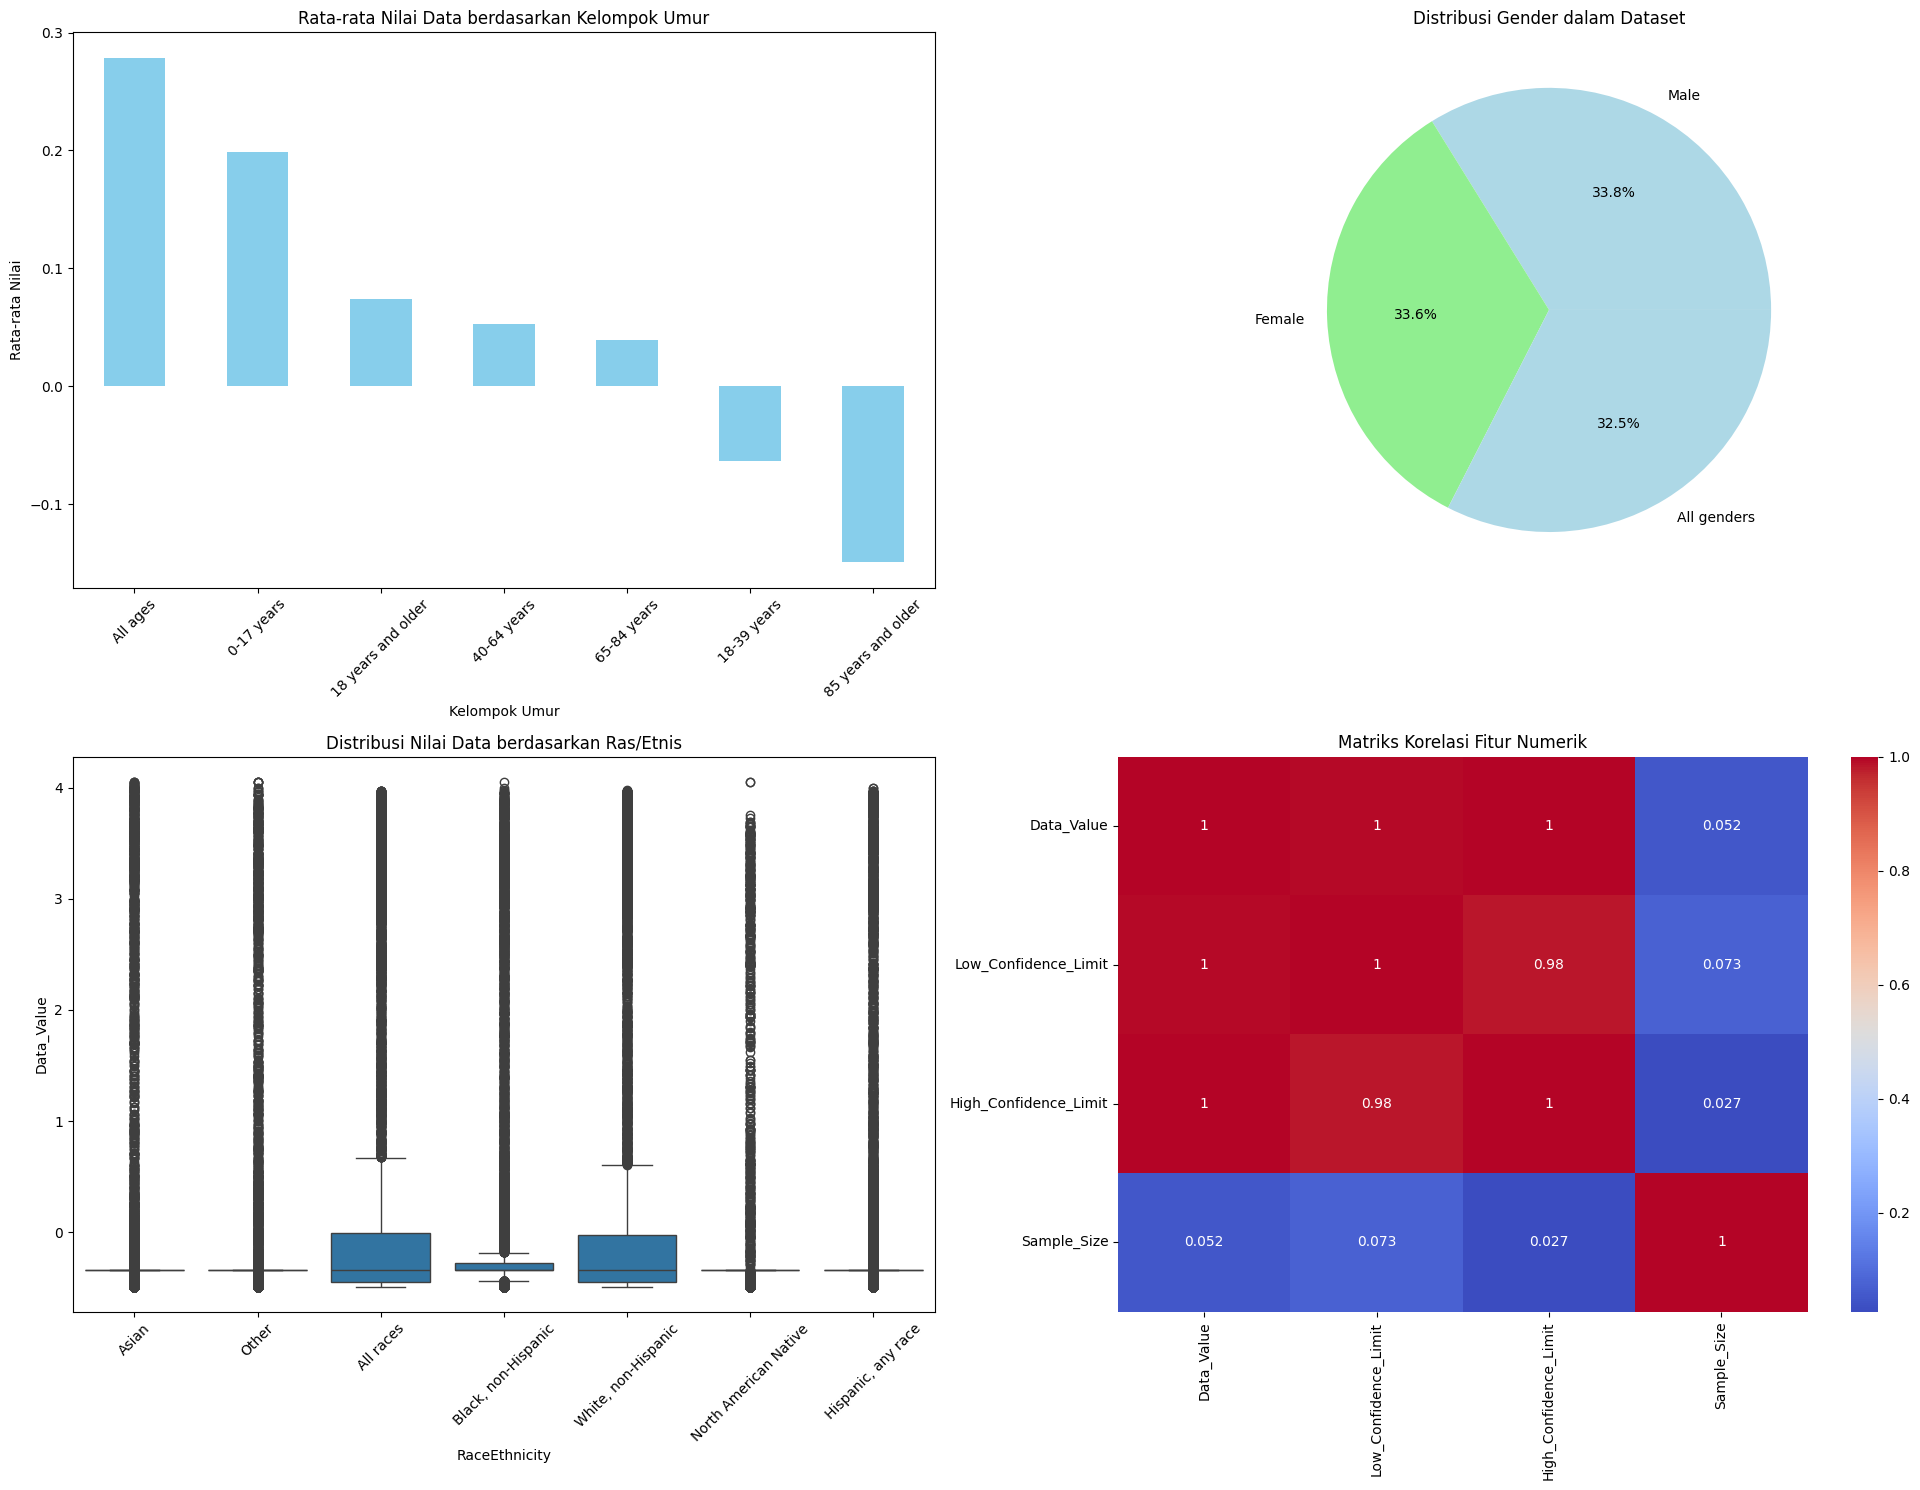

In [ ]:
print("\n# 3. Analisis Data Eksploratif")

plt.figure(figsize=(20, 15))

# 1. Bar Chart: Rata-rata Data Value berdasarkan Kelompok Umur
plt.subplot(2, 2, 1)
age_data = df_cleaned.groupby('Age')['Data_Value'].mean().sort_values(ascending=False)
age_data.plot(kind='bar', color='skyblue')
plt.title('Rata-rata Nilai Data berdasarkan Kelompok Umur')
plt.xlabel('Kelompok Umur')
plt.ylabel('Rata-rata Nilai')
plt.xticks(rotation=45)

# 2. Pie Chart: Distribusi Gender
plt.subplot(2, 2, 2)
gender_dist = df_cleaned['Gender'].value_counts()
plt.pie(gender_dist, labels=gender_dist.index, autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
plt.title('Distribusi Gender dalam Dataset')

# 3. Box Plot: Distribusi Data Value berdasarkan Ras/Etnis
plt.subplot(2, 2, 3)
sns.boxplot(data=df_cleaned, x='RaceEthnicity', y='Data_Value')
plt.xticks(rotation=45)
plt.title('Distribusi Nilai Data berdasarkan Ras/Etnis')

# 4. Correlation Matrix
plt.subplot(2, 2, 4)
correlation_matrix = df_cleaned[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriks Korelasi Fitur Numerik')

plt.tight_layout()
plt.show()

# BAGIAN 4: PEMILIHAN FITUR DAN PERSIAPAN MODEL

In [ ]:
print("\n# 4. Pemilihan Fitur dan Persiapan Model")

# Konversi ke Spark DataFrame
spark_df = spark.createDataFrame(df_cleaned)

# Persiapan fitur untuk model
vector_assembler = VectorAssembler(
    inputCols=numerical_cols,
    outputCol="features"
)

# Transform data
spark_df = vector_assembler.transform(spark_df)

# Persiapan label
spark_df = spark_df.withColumn("label",
    (spark_df["Data_Value"] > spark_df.select(F.avg("Data_Value")).first()[0]).cast("double"))

# Split data
train_data, test_data = spark_df.randomSplit([0.8, 0.2], seed=42)


# 4. Pemilihan Fitur dan Persiapan Model


# 5. Pengembangan dan Evaluasi Model

In [ ]:
# BAGIAN 5: PENGEMBANGAN MODEL

print("\n# 5. Pengembangan dan Evaluasi Model")
# Inisialisasi model
# Inisialisasi model
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=100)
gbt = GBTClassifier(labelCol="label", featuresCol="features", maxIter=10)
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)

# Dictionary untuk menyimpan model
models = {
    'Random Forest': rf,
    'Gradient Boosting Tree': gbt,
    'Logistic Regression': lr
}

# Evaluator
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")

# Training dan evaluasi model
for name, model in models.items():
    print(f"\nHasil Model {name}:")
    model_fit = model.fit(train_data)
    predictions = model_fit.transform(test_data)

    # Evaluasi
    auc_score = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    print(f"AUC Score: {auc_score:.4f}")

    if name == 'Random Forest':
        # Feature importance untuk Random Forest
        try:
            feature_importance = pd.DataFrame(
                model_fit.featureImportances.toArray(),
                index=numerical_cols,
                columns=['importance']
            ).sort_values('importance', ascending=False)
            print("\nPentingnya Fitur:")
            print(feature_importance)
        except Exception as e:
            print(f"Error extracting feature importance: {e}")


# 5. Pengembangan dan Evaluasi Model

Hasil Model Random Forest:
AUC Score: 0.9945

Pentingnya Fitur:
                       importance
High_Confidence_Limit    0.435691
Data_Value               0.375865
Low_Confidence_Limit     0.187148
Sample_Size              0.001295

Hasil Model Gradient Boosting Tree:
AUC Score: 0.9913

Hasil Model Logistic Regression:
AUC Score: 0.9946


# BAGIAN 6: HYPERPARAMETER TUNING UNTUK MODEL TERBAIK

In [ ]:
print("\n# 6. Hyperparameter Tuning")

# Pilih model terbaik berdasarkan F1 Score
best_model_name = max(results.items(), key=lambda x: x[1]['F1'])[0]
print(f"Model terbaik: {best_model_name}")

# ParamGrid untuk Random Forest
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [50, 100, 200]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .addGrid(rf.minInstancesPerNode, [1, 2, 4]) \
    .build()

# Cross Validator
crossval = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator_binary,
    numFolds=3
)

# Fit model terbaik
cvModel = crossval.fit(train_data)
print("\nParameter Terbaik:", cvModel.getEstimatorParamMaps()[np.argmax(cvModel.avgMetrics)])
print("Skor Terbaik:", max(cvModel.avgMetrics))


# 6. Hyperparameter Tuning
Model terbaik: Random Forest

Parameter Terbaik: {Param(parent='RandomForestClassifier_a484acdc613f', name='numTrees', doc='Number of trees to train (>= 1).'): 50, Param(parent='RandomForestClassifier_a484acdc613f', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 10, Param(parent='RandomForestClassifier_a484acdc613f', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 2}
Skor Terbaik: 0.999991815106971



# 7. Analisis Karakteristik Model Final

Metrik Final:
AUC: 0.9945

Pentingnya Fitur Model Final:
                       importance
High_Confidence_Limit    0.435691
Data_Value               0.375865
Low_Confidence_Limit     0.187148
Sample_Size              0.001295


<Figure size 1000x600 with 0 Axes>

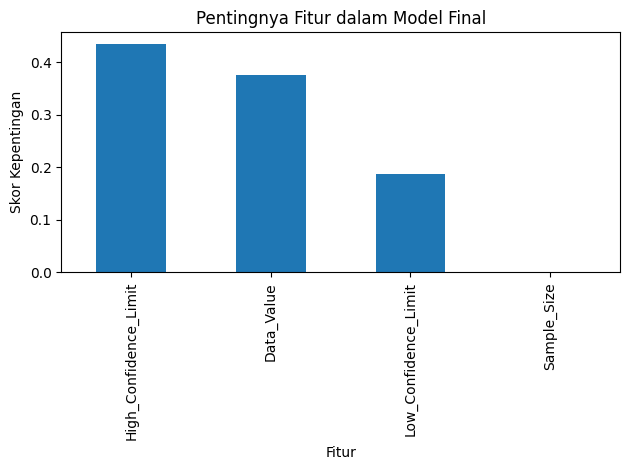

In [ ]:
print("\n# 7. Analisis Karakteristik Model Final")

# Evaluasi final pada model terbaik
best_model = rf.fit(train_data)  # Misal Random Forest adalah model terbaik
predictions_final = best_model.transform(test_data)

final_metrics = {
    "AUC": evaluator.evaluate(predictions_final, {evaluator.metricName: "areaUnderROC"}),
}

print("\nMetrik Final:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")

# Feature importance final
try:
    feature_importance_final = pd.DataFrame(
        best_model.featureImportances.toArray(),
        index=numerical_cols,
        columns=['importance']
    ).sort_values('importance', ascending=False)

    print("\nPentingnya Fitur Model Final:")
    print(feature_importance_final)

    # Visualisasi feature importance
    plt.figure(figsize=(10, 6))
    feature_importance_final.plot(kind='bar', legend=False)
    plt.title('Pentingnya Fitur dalam Model Final')
    plt.xlabel('Fitur')
    plt.ylabel('Skor Kepentingan')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error extracting or visualizing feature importance: {e}")